In [3]:
!pip install datasets
from datasets import load_dataset

In [ ]:
dataset = load_dataset("RicardoRei/wmt-da-human-evaluation", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
df = dataset.to_pandas()
df.head()

In [ ]:
pairs = df["lp"].unique()
pairs

In [ ]:
!pip install iso-639
from iso639 import languages

def translate_language_pair(lp):
  l1, l2 = lp.split('-')
  return f"{languages.get(alpha2=l1).name} -> {languages.get(alpha2=l2).name}"


for pair in pairs:
  print(translate_language_pair(pair))

In [ ]:
langs = set()
for pair in pairs:
  l1, l2 = pair.split('-')
  langs.add(l1)
  langs.add(l2)

all_languages = list(map(lambda x: languages.get(alpha2=x).name, langs))
all_languages

['Japanese',
 'Russian',
 'French',
 'Tamil',
 'Zulu',
 'Xhosa',
 'Icelandic',
 'Czech',
 'Ukrainian',
 'Polish',
 'Turkish',
 'German',
 'Bengali',
 'Hindi',
 'Hausa',
 'Finnish',
 'Gujarati',
 'English',
 'Chinese',
 'Central Khmer',
 'Pushto',
 'Estonian',
 'Latvian',
 'Kazakh',
 'Lithuanian']

In [ ]:
by_annotators = df[['lp', 'annotators', 'src']].groupby(['lp', 'annotators']).agg('count').rename(columns={'src': 'count'}).reset_index()
by_annotators

,lp,annotators,count
0,bn-hi,1,4461
1,cs-en,1,38636
2,cs-en,2,9641
3,cs-en,3,2203
4,cs-en,4,399
...,...,...,...
195,zh-en,6,33
196,zh-en,7,2
197,zh-en,8,10
198,zh-en,9,1


In [ ]:
min_number_of_annotators = 4

most_common = by_annotators[by_annotators["annotators"]>=min_number_of_annotators][["lp", "count"]].groupby("lp").agg("sum").sort_values("count", ascending=False)
most_common = most_common.reset_index()
most_common["pair"] = most_common["lp"].map(translate_language_pair)

most_common = most_common[["lp", "pair", "count"]]
most_common

,lp,pair,count
0,en-zh,English -> Chinese,7062
1,de-en,German -> English,1929
2,en-cs,English -> Czech,1900
3,en-de,English -> German,1322
4,en-ja,English -> Japanese,1116
5,en-ru,English -> Russian,1106
6,zh-en,Chinese -> English,967
7,fi-en,Finnish -> English,952
8,tr-en,Turkish -> English,853
9,lt-en,Lithuanian -> English,846


In [ ]:
possible_pairs = [
    "en-zh", # It's okay because too many checkers, and also
    "en-cs",
    "en-de",
    "fi-en"
]

In [ ]:
min_number_of_annotators = 1

not_english = by_annotators[by_annotators["lp"].map(lambda x: not 'en' in x)]

most_common = not_english[not_english["annotators"]>=min_number_of_annotators][["lp", "count"]].groupby("lp").agg("sum").sort_values("count", ascending=False)
most_common = most_common.reset_index()
most_common["pair"] = most_common["lp"].map(translate_language_pair)

most_common = most_common[["lp", "pair", "count"]]
most_common

,lp,pair,count
0,de-fr,German -> French,14949
1,de-cs,German -> Czech,13804
2,fr-de,French -> German,11195
3,hi-bn,Hindi -> Bengali,4512
4,bn-hi,Bengali -> Hindi,4461
5,xh-zu,Xhosa -> Zulu,2968
6,zu-xh,Zulu -> Xhosa,2502


In [ ]:
not_english_possible_pairs = [
    "de-fr",
    "de-cs",
    "hi-bn",
    "xh-zu"
]

In [ ]:
import pandas as pd

def generate_dataset(df, pairs, num_of_rows, num_annotators):
  out = None
  for pair in pairs:
    aux = df[df["lp"]==pair]
    aux = aux[aux["annotators"]>=num_annotators]
    sample = aux.sample(num_of_rows)

    if out is not None:
      out = pd.concat([out, sample])
    else:
      out = sample

  return out

In [ ]:
possible_pairs = [
    "en-zh", # It's okay because too many checkers, and also
    "en-cs",
    "en-de",
    "fi-en"
]

out1 = generate_dataset(df, possible_pairs, 300, 4)
out1

,lp,src,mt,ref,score,raw,annotators,domain,year
69066,en-zh,"According to Sun Ze, it must rely on the detec...",根据孙泽的说法，它必须依靠探测器完成整个过程，因为地球和火星之间的距离相当大。,孙泽洲说，由于地球与火星距离遥远，整个过程无法由地面实时控制，所以必须依靠探测器自主完成。,0.246028,76.666667,6,news,2017
786744,en-zh,"Trump will likely veto the resolution, the six...",特朗普可能会否决该决议，这将是他第六次以总统身份阻止国会立法，他已经在3月否决了一项结束紧急...,特朗普可能会否决该决议，这将是他第六次以总统身份阻止国会立法。三月份他已经否决了一项终止紧急...,0.546598,87.600000,5,news,2020
782995,en-zh,But the move attracted praise from some social...,但这一举动吸引了一些社交媒体用户的赞誉.,尽管如此，此举在社交媒体上赢得一些用户的称赞。,0.645324,92.000000,4,news,2020
777563,en-zh,"In June, the government had compulsorily retir...",今年 6 月 ， 政府以贪污罪、收受贿赂、走私、甚至共谋犯罪等罪名强制退休了银保监会的 15...,今年 6 月，政府以贪污、收受贿赂、走私甚至共谋犯罪等罪名，强制 15 名中央间接税和海关委...,0.008526,59.400000,5,news,2020
805216,en-zh,House Speaker Nancy Pelosi accused U.S. Attorn...,众议院议长南希·佩洛西(Nancy Pelosi)指控美国总检察长威廉·巴尔·星期五“傲慢”...,众议院议长南希·佩洛西指责美国总检察长威廉·巴尔周五为保护总统唐纳德·特朗普而耍“无赖”。特...,-0.041999,71.666667,6,news,2020
...,...,...,...,...,...,...,...,...,...
115046,fi-en,Meidän ei pidä lietsoa ihmisiä panikoimaan ene...,"We should not let people panic more, he told r...",We should not stir up any more panic in the pe...,0.334128,67.250000,4,news,2017
494127,fi-en,"Saksassa KGB hankki DRG-ryhmille Bundeswehrin,...","In Germany, the KGB acquired the uniforms and ...","In Germany, KGB acquired Bunderswehr, railroad...",0.534632,83.750000,4,news,2019
120302,fi-en,Viimeisen kahden kuukauden aikana olemme kesku...,In the last two months we have discussed with ...,Over the last two months we have been talking ...,0.597380,83.750000,4,news,2017
109712,fi-en,Heinäkuun puolivälissä 85 ihmistä kuoli ja sat...,"In mid-July, 85 people were killed and hundred...",In mid-July 85 people were killed and hundreds...,0.839959,95.250000,4,news,2017


In [ ]:
not_english_possible_pairs = [
    "de-fr",
    "de-cs",
    "hi-bn",
    "xh-zu"
]

out2 = generate_dataset(df, not_english_possible_pairs, 300, 1)
out2

,lp,src,mt,ref,score,raw,annotators,domain,year
566336,de-fr,Der Grünen-Innenpolitiker Konstantin von Notz ...,"Le politicien d ' intérieur, Constantin von No...",L’homme politique de l’intérieur du parti des ...,-1.345712,23.0,1,news,2019
572205,de-fr,"Die lehnen 53 Prozent von allen ab, die Deutsc...","Ils sont 53 % à s'y opposer, les Allemands son...","53 pourcent de tous refusent, les allemands so...",1.530060,98.0,1,news,2019
571197,de-fr,Und Parteichefin Katja Kipping sprach sogar üb...,"Et la dirigeante du parti, Katja Kipping, a mê...",Et la cheffe de parti Katja Kipping a même par...,0.169075,64.0,1,news,2019
568184,de-fr,Das liegt einfach in den Genen der europäische...,C'est simplement dans les gènes de la famille ...,C'est tout simplement dans les gènes de la fam...,1.149560,100.0,1,news,2019
567979,de-fr,In seinem Text weist der Abgeordnete der Regio...,"Dans son texte, le membre de la région des Bou...","Dans son texte, le député des Bouches-du-Rhône...",-0.560153,75.0,1,news,2019
...,...,...,...,...,...,...,...,...,...
1167251,xh-zu,"Imbaleki ejikeleze kakuhle, ihlosi liyakwazi u...","Umgijimi oyindilinga kahle, ihlosi liyakwazi u...","Umgadli ophelele, ihlosi lingakhuphuka (yize l...",0.579874,98.0,1,wiki,2021
1169177,xh-zu,Uxinzelelo lomkhuhlane weentaka obulala abantu...,Ingcindezi yomkhuhlane wezinyoni obulale abant...,Uhlobo lomkhuhlane wezinyoni olubulalayo ebant...,-0.754106,15.0,1,wiki,2021
1168073,xh-zu,UProfesa Pamela Ferguson waseUniversity of Dun...,UProfesa Pamela Ferguson wase-University of Du...,UProfesa Pamela Ferguson wase Nyuvesi yase-Dun...,-0.110636,35.0,1,wiki,2021
1170055,xh-zu,"wayivingca, wasinda kulomaxesha, unika umfanek...","Wayivala, wasinda kulezi zikhathi, enikeza isi...","Umhume ngokwawo, obekhona kuze kube manje, uni...",1.626733,89.0,1,wiki,2021


In [ ]:
last_df = pd.concat([out1, out2])
last_df.reset_index(drop=True, inplace=True)

In [ ]:
last_df["l1"] = last_df["lp"].map(lambda x: x[:2])
last_df["l2"] = last_df["lp"].map(lambda x: x[-2:])

last_df

,lp,src,mt,ref,score,raw,annotators,domain,year,l1,l2
0,en-zh,"According to Sun Ze, it must rely on the detec...",根据孙泽的说法，它必须依靠探测器完成整个过程，因为地球和火星之间的距离相当大。,孙泽洲说，由于地球与火星距离遥远，整个过程无法由地面实时控制，所以必须依靠探测器自主完成。,0.246028,76.666667,6,news,2017,en,zh
1,en-zh,"Trump will likely veto the resolution, the six...",特朗普可能会否决该决议，这将是他第六次以总统身份阻止国会立法，他已经在3月否决了一项结束紧急...,特朗普可能会否决该决议，这将是他第六次以总统身份阻止国会立法。三月份他已经否决了一项终止紧急...,0.546598,87.600000,5,news,2020,en,zh
2,en-zh,But the move attracted praise from some social...,但这一举动吸引了一些社交媒体用户的赞誉.,尽管如此，此举在社交媒体上赢得一些用户的称赞。,0.645324,92.000000,4,news,2020,en,zh
3,en-zh,"In June, the government had compulsorily retir...",今年 6 月 ， 政府以贪污罪、收受贿赂、走私、甚至共谋犯罪等罪名强制退休了银保监会的 15...,今年 6 月，政府以贪污、收受贿赂、走私甚至共谋犯罪等罪名，强制 15 名中央间接税和海关委...,0.008526,59.400000,5,news,2020,en,zh
4,en-zh,House Speaker Nancy Pelosi accused U.S. Attorn...,众议院议长南希·佩洛西(Nancy Pelosi)指控美国总检察长威廉·巴尔·星期五“傲慢”...,众议院议长南希·佩洛西指责美国总检察长威廉·巴尔周五为保护总统唐纳德·特朗普而耍“无赖”。特...,-0.041999,71.666667,6,news,2020,en,zh
...,...,...,...,...,...,...,...,...,...,...,...
2395,xh-zu,"Imbaleki ejikeleze kakuhle, ihlosi liyakwazi u...","Umgijimi oyindilinga kahle, ihlosi liyakwazi u...","Umgadli ophelele, ihlosi lingakhuphuka (yize l...",0.579874,98.000000,1,wiki,2021,xh,zu
2396,xh-zu,Uxinzelelo lomkhuhlane weentaka obulala abantu...,Ingcindezi yomkhuhlane wezinyoni obulale abant...,Uhlobo lomkhuhlane wezinyoni olubulalayo ebant...,-0.754106,15.000000,1,wiki,2021,xh,zu
2397,xh-zu,UProfesa Pamela Ferguson waseUniversity of Dun...,UProfesa Pamela Ferguson wase-University of Du...,UProfesa Pamela Ferguson wase Nyuvesi yase-Dun...,-0.110636,35.000000,1,wiki,2021,xh,zu
2398,xh-zu,"wayivingca, wasinda kulomaxesha, unika umfanek...","Wayivala, wasinda kulezi zikhathi, enikeza isi...","Umhume ngokwawo, obekhona kuze kube manje, uni...",1.626733,89.000000,1,wiki,2021,xh,zu


In [ ]:
#!pip install evaluate
#!pip install sacrebleu
#!pip install unbabel-comet
import evaluate

sacrebleu = evaluate.load("sacrebleu")
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
comet = evaluate.load("comet")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 32.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

hparams.yaml:   0%|          | 0.00/567 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.53k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/2.32G [00:00<?, ?B/s]

LICENSE:   0%|          | 0.00/9.69k [00:00<?, ?B/s]

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/371e9839ca4e213dde891b066cf3080f75ec7e72/checkpoints/model.ckpt`
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [ ]:
def calculate_metric(row, metric, metric_name, takes_sources=False):
  ref = [row["ref"]]
  trans = row["mt"]
  source = row["src"]
  if takes_sources:
    return metric.compute(predictions=[trans], references=ref, sources=[source])[metric_name]
  else:
    return metric.compute(predictions=[trans], references=[ref])[metric_name]

In [ ]:
last_df["bleu"] = 100*last_df.apply(lambda x: calculate_metric(x, bleu, "bleu"), axis=1)
last_df["sacrebleu"] = last_df.apply(lambda x: calculate_metric(x, sacrebleu, "score"), axis=1)
last_df["meteor"] = 100*last_df.apply(lambda x: calculate_metric(x, meteor, "meteor"), axis=1)

In [ ]:
#last_df["comet"] = last_df.apply(lambda x: calculate_metric(x, comet, "scores", True), axis=1)

In [ ]:
last_df

,lp,src,mt,ref,score,raw,annotators,domain,year,l1,l2,bleu,sacrebleu,meteor,mapper
0,en-zh,"According to Sun Ze, it must rely on the detec...",根据孙泽的说法，它必须依靠探测器完成整个过程，因为地球和火星之间的距离相当大。,孙泽洲说，由于地球与火星距离遥远，整个过程无法由地面实时控制，所以必须依靠探测器自主完成。,0.246028,76.666667,6,news,2017,en,zh,0.0000,0.000000,0.000000,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
1,en-zh,"Trump will likely veto the resolution, the six...",特朗普可能会否决该决议，这将是他第六次以总统身份阻止国会立法，他已经在3月否决了一项结束紧急...,特朗普可能会否决该决议，这将是他第六次以总统身份阻止国会立法。三月份他已经否决了一项终止紧急...,0.546598,87.600000,5,news,2020,en,zh,0.0000,0.000000,0.000000,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
2,en-zh,But the move attracted praise from some social...,但这一举动吸引了一些社交媒体用户的赞誉.,尽管如此，此举在社交媒体上赢得一些用户的称赞。,0.645324,92.000000,4,news,2020,en,zh,0.0000,0.000000,0.000000,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
3,en-zh,"In June, the government had compulsorily retir...",今年 6 月 ， 政府以贪污罪、收受贿赂、走私、甚至共谋犯罪等罪名强制退休了银保监会的 15...,今年 6 月，政府以贪污、收受贿赂、走私甚至共谋犯罪等罪名，强制 15 名中央间接税和海关委...,0.008526,59.400000,5,news,2020,en,zh,0.0000,3.582342,32.538660,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
4,en-zh,House Speaker Nancy Pelosi accused U.S. Attorn...,众议院议长南希·佩洛西(Nancy Pelosi)指控美国总检察长威廉·巴尔·星期五“傲慢”...,众议院议长南希·佩洛西指责美国总检察长威廉·巴尔周五为保护总统唐纳德·特朗普而耍“无赖”。特...,-0.041999,71.666667,6,news,2020,en,zh,0.0000,0.000000,16.949153,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,xh-zu,"Imbaleki ejikeleze kakuhle, ihlosi liyakwazi u...","Umgijimi oyindilinga kahle, ihlosi liyakwazi u...","Umgadli ophelele, ihlosi lingakhuphuka (yize l...",0.579874,98.000000,1,wiki,2021,xh,zu,0.0000,5.463336,28.918975,"{'[ORIGINAL LANGUAGE]': 'xh', '[TRANSLATED LAN..."
2396,xh-zu,Uxinzelelo lomkhuhlane weentaka obulala abantu...,Ingcindezi yomkhuhlane wezinyoni obulale abant...,Uhlobo lomkhuhlane wezinyoni olubulalayo ebant...,-0.754106,15.000000,1,wiki,2021,xh,zu,0.0000,13.471767,52.891156,"{'[ORIGINAL LANGUAGE]': 'xh', '[TRANSLATED LAN..."
2397,xh-zu,UProfesa Pamela Ferguson waseUniversity of Dun...,UProfesa Pamela Ferguson wase-University of Du...,UProfesa Pamela Ferguson wase Nyuvesi yase-Dun...,-0.110636,35.000000,1,wiki,2021,xh,zu,0.0000,8.097785,24.505495,"{'[ORIGINAL LANGUAGE]': 'xh', '[TRANSLATED LAN..."
2398,xh-zu,"wayivingca, wasinda kulomaxesha, unika umfanek...","Wayivala, wasinda kulezi zikhathi, enikeza isi...","Umhume ngokwawo, obekhona kuze kube manje, uni...",1.626733,89.000000,1,wiki,2021,xh,zu,0.0000,12.185144,38.678985,"{'[ORIGINAL LANGUAGE]': 'xh', '[TRANSLATED LAN..."


In [ ]:
def generate_mapper(row):
  return {
        "[ORIGINAL LANGUAGE]": row["l1"],
        "[TRANSLATED LANGUAGE]": row["l2"],
        "[ORIGINAL TEXT]": row["src"],
        "[TRANSLATED TEXT]": row["mt"],
    }

In [ ]:
last_df["mapper"] = last_df.apply(generate_mapper, axis=1)

In [ ]:
last_df

,lp,src,mt,ref,score,raw,annotators,domain,year,l1,l2,bleu,sacrebleu,meteor,mapper
0,en-zh,"According to Sun Ze, it must rely on the detec...",根据孙泽的说法，它必须依靠探测器完成整个过程，因为地球和火星之间的距离相当大。,孙泽洲说，由于地球与火星距离遥远，整个过程无法由地面实时控制，所以必须依靠探测器自主完成。,0.246028,76.666667,6,news,2017,en,zh,0.0000,0.000000,0.000000,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
1,en-zh,"Trump will likely veto the resolution, the six...",特朗普可能会否决该决议，这将是他第六次以总统身份阻止国会立法，他已经在3月否决了一项结束紧急...,特朗普可能会否决该决议，这将是他第六次以总统身份阻止国会立法。三月份他已经否决了一项终止紧急...,0.546598,87.600000,5,news,2020,en,zh,0.0000,0.000000,0.000000,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
2,en-zh,But the move attracted praise from some social...,但这一举动吸引了一些社交媒体用户的赞誉.,尽管如此，此举在社交媒体上赢得一些用户的称赞。,0.645324,92.000000,4,news,2020,en,zh,0.0000,0.000000,0.000000,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
3,en-zh,"In June, the government had compulsorily retir...",今年 6 月 ， 政府以贪污罪、收受贿赂、走私、甚至共谋犯罪等罪名强制退休了银保监会的 15...,今年 6 月，政府以贪污、收受贿赂、走私甚至共谋犯罪等罪名，强制 15 名中央间接税和海关委...,0.008526,59.400000,5,news,2020,en,zh,0.0000,3.582342,32.538660,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
4,en-zh,House Speaker Nancy Pelosi accused U.S. Attorn...,众议院议长南希·佩洛西(Nancy Pelosi)指控美国总检察长威廉·巴尔·星期五“傲慢”...,众议院议长南希·佩洛西指责美国总检察长威廉·巴尔周五为保护总统唐纳德·特朗普而耍“无赖”。特...,-0.041999,71.666667,6,news,2020,en,zh,0.0000,0.000000,16.949153,"{'[ORIGINAL LANGUAGE]': 'en', '[TRANSLATED LAN..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,xh-zu,"Imbaleki ejikeleze kakuhle, ihlosi liyakwazi u...","Umgijimi oyindilinga kahle, ihlosi liyakwazi u...","Umgadli ophelele, ihlosi lingakhuphuka (yize l...",0.579874,98.000000,1,wiki,2021,xh,zu,0.0000,5.463336,28.918975,"{'[ORIGINAL LANGUAGE]': 'xh', '[TRANSLATED LAN..."
2396,xh-zu,Uxinzelelo lomkhuhlane weentaka obulala abantu...,Ingcindezi yomkhuhlane wezinyoni obulale abant...,Uhlobo lomkhuhlane wezinyoni olubulalayo ebant...,-0.754106,15.000000,1,wiki,2021,xh,zu,0.0000,13.471767,52.891156,"{'[ORIGINAL LANGUAGE]': 'xh', '[TRANSLATED LAN..."
2397,xh-zu,UProfesa Pamela Ferguson waseUniversity of Dun...,UProfesa Pamela Ferguson wase-University of Du...,UProfesa Pamela Ferguson wase Nyuvesi yase-Dun...,-0.110636,35.000000,1,wiki,2021,xh,zu,0.0000,8.097785,24.505495,"{'[ORIGINAL LANGUAGE]': 'xh', '[TRANSLATED LAN..."
2398,xh-zu,"wayivingca, wasinda kulomaxesha, unika umfanek...","Wayivala, wasinda kulezi zikhathi, enikeza isi...","Umhume ngokwawo, obekhona kuze kube manje, uni...",1.626733,89.000000,1,wiki,2021,xh,zu,0.0000,12.185144,38.678985,"{'[ORIGINAL LANGUAGE]': 'xh', '[TRANSLATED LAN..."


In [ ]:
import os
import multiprocessing
import re

from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

def get_prompt(PROMT_TEMPLATE: str, mapper: dict):
    prompt = PROMT_TEMPLATE
    for tag, value in mapper.items():
        prompt = prompt.replace(tag, value)

    return prompt

def send_message_mistral(
    client: MistralClient, message: str, mistral_model="open-mistral-7b"
) -> str:
    """
    Send a message to the Mistral API and return the response.

    Parameters:
        client: Mistral API client.
        message: The message to send to the API.

    Returns:
        str: Model response.
    """
    messages = [ChatMessage(role="user", content=message)]
    chat_response = client.chat(
        model=mistral_model,
        messages=messages,
    )
    return chat_response.choices[0].message.content


def ask_mistral_for_evaluation(client, prompt_template, mapper, mistral_model="open-mistral-7b"):
    message = get_prompt(prompt_template, mapper)
    response = send_message_mistral(client=client, message=message, mistral_model=mistral_model)
    match = re.match(r"\d+", response)
    if match:
        score = int(match)

    return response, score

In [ ]:
bleurt = load("bleurt", module_type="metric")

NameError: name 'load' is not defined

In [ ]:
def get_bar_plot(df, lang_pairs, bar_size, column, new_column):
  aux = df[df["lp"]==lang_pairs]

  aux[new_column] = aux[column].map(lambda x: bar_size*int(x//bar_size))
  aux.groupby(new_column).agg('count')['lp'].plot.bar()

<ipython-input-61-3a4bc06fccfe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux[new_column] = aux[column].map(lambda x: bar_size*int(x//bar_size))


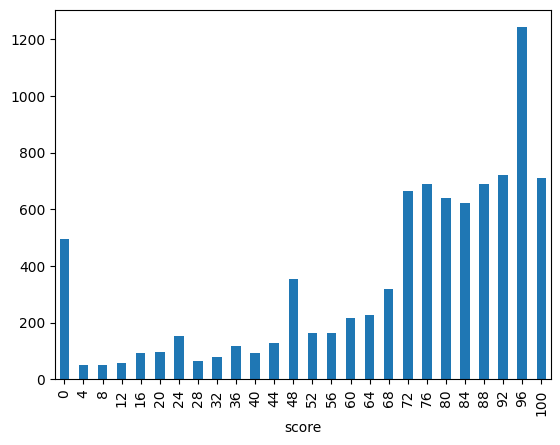

In [ ]:
get_bar_plot(df, 'is-en', 4, 'raw', 'score')

In [ ]:
get_bar_plot(df, 'is-en', 4, 'raw', 'score')

In [ ]:
by_annotators[by_annotators["lp"]=="is-en"]

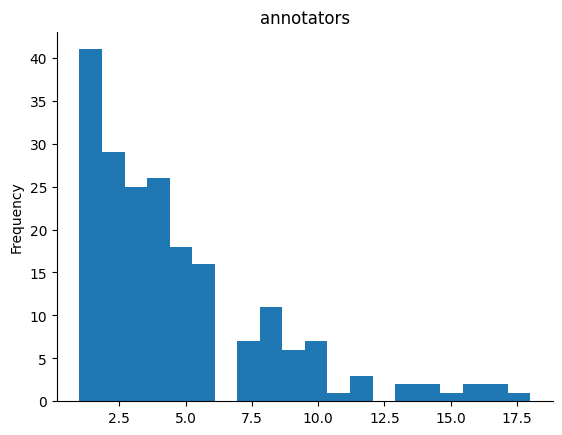

In [ ]:
# @title annotators

from matplotlib import pyplot as plt
by_annotators['annotators'].plot(kind='hist', bins=20, title='annotators')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
by_annotators[by_annotators["lp"]=='en-de']

,lp,annotators,count
37,en-de,1,96683
38,en-de,2,25251
39,en-de,3,2736
40,en-de,4,848
41,en-de,5,116
42,en-de,6,188
43,en-de,7,42
44,en-de,8,51
45,en-de,9,50
46,en-de,10,12


In [ ]:
by_annotators[by_annotators["lp"]=='de-en']

,lp,annotators,count
11,de-en,1,105112
12,de-en,2,24594
13,de-en,3,3161
14,de-en,4,1681
15,de-en,5,44
16,de-en,6,178
17,de-en,7,6
18,de-en,8,18
19,de-en,9,2


In [ ]:
from collections import Counter

def get_all_ngrams(text: list, n: int):
    """
        Takes a text and returns all ngrams.
    """
    m = len(text) + 1 - n
    n_grams = [
        tuple(text[i:n+i]) for i in range(m)
    ]
    return n_grams


def split_by_char(text: str)->list:
    """
        Takes a text and splits it characterwise.
    """
    return tuple(text.replace(' ', '_'))


def chrP(hypothesis: str, reference: str, n: int)->float:
    """
        Returns chrP
    """
    hyp_n = Counter(get_all_ngrams(hypothesis.split(), n))
    ref_n = Counter(get_all_ngrams(reference.split(), n))

    if sum(hyp_n.values())==0:
      return 0

    return sum(min(hyp_n[key], ref_n[key]) for key in hyp_n.keys()) / sum(hyp_n.values())


def chrR(hypothesis: str, reference: str, n: int)->float:
    """
        Returns chrR
    """
    hyp_n = Counter(get_all_ngrams(split_by_char(hypothesis), n))
    ref_n = Counter(get_all_ngrams(split_by_char(reference), n))

    if sum(hyp_n.values())==0:
      return 0
    print(sum(min(hyp_n[key], ref_n[key]) for key in hyp_n.keys()))
    print(sum(hyp_n.values()))

    return sum(min(hyp_n[key], ref_n[key]) for key in hyp_n.keys()) / sum(hyp_n.values())


def chrF(hypothesis: str, reference: str, n: int, beta_: float)->float:
    """
        Returns chrF
    """
    p = chrP(hypothesis, reference, n)
    r = chrR(hypothesis, reference, n)

    if p==0 or r==0:
      return 0

    return (1 + beta_) * (p * r) / (beta_*p + r)


print(
    get_all_ngrams(
        "hola me llamo ruben y soy de granada".split(), 4)
)

print(
    chrP(
        "hola me llamo ruben y soy de granada",
        "hola me llamo ruben y soy de malaga", 4)
)

print(
    chrR(
        "hola me llamo ruben y soy de granada",
        "hola me llamo ruben y soy de malaga", 4)
)

print(
    chrF(
        "hola me llamo ruben y soy de granada",
        "hola me llamo ruben y soy de malaga", 4, 1)
)

print(
    split_by_char("This is an example.")
)

[('hola', 'me', 'llamo', 'ruben'), ('me', 'llamo', 'ruben', 'y'), ('llamo', 'ruben', 'y', 'soy'), ('ruben', 'y', 'soy', 'de'), ('y', 'soy', 'de', 'granada')]
0.8
26
33
0.7878787878787878
26
33
0.7938931297709925
('T', 'h', 'i', 's', '_', 'i', 's', '_', 'a', 'n', '_', 'e', 'x', 'a', 'm', 'p', 'l', 'e', '.')


In [ ]:
chrP("My name is Ruben and I am from Granada .", "My name is Ruben and I am from Malaga .", 4)

0.7142857142857143

In [ ]:
chrF("My name is Ruben and I am from Granada .", "My name is Ruben and I am from Malaga .", 4, 1)

28
37


0.7349081364829397

In [ ]:
chrP("Jaký je váš pohled na zápas?", "Jak byste zhodnotily zápas?", 4)
chrR("Jaký je váš pohled na zápas?", "Jak byste zhodnotily zápas?", 4)

0.16

In [ ]:
df = dataset.to_pandas()

In [ ]:
df["from"] = df["lp"].map(lambda x: x[:2])
df["to"] = df["lp"].map(lambda x: x[-2:])
df["human_score"] = df["raw"]


data = df[['from', 'to', 'src', 'mt', 'ref', 'human_score']]
data = data.dropna()
data.head()

,from,to,src,mt,ref,human_score
0,en,cs,What is your view of the match?,Jaký je váš pohled na zápas?,Jak byste zhodnotily zápas?,89.214286
1,en,cs,I actually haven't asked for a prognosis in fo...,"Vlastně jsem se neptal na prognózu věčnost, pr...","Ve skutečnosti jsem se nikdy neptala, jaká je ...",50.066667
2,en,cs,Knowledge of a foreign language is useful in a...,Znalost cizího jazyka je užitečné v každém pov...,"Znalost cizího jazyka se hodí v každé profesí,...",79.500000
3,en,cs,U.S. Men's Archery Team member Brady Ellison h...,U.S. Men &apos;s Archery Team member Brady Ell...,Závodník z tým amerických lukostřelců Brady El...,11.000000
4,en,cs,"No, we focus our marketing effort on the Czech...","Ne, zaměřujeme naše marketingové úsilí České r...","Ne, marketing jsme zaměřili na Česko, kde se s...",63.000000


In [ ]:
len(df)

1285190

In [ ]:
len(data)

1285180

In [ ]:
data["chrF"] = data.apply(lambda row: 100*chrF(row.mt, row.ref, 4, 1), axis=1)
data["chrF3"] = data.apply(lambda row: 100*chrF(row.mt, row.ref, 4, 9), axis=1)

data

,from,to,src,mt,ref,human_score,chrF,chrF3
0,en,cs,What is your view of the match?,Jaký je váš pohled na zápas?,Jak byste zhodnotily zápas?,89.214286,0.000000,0.000000
1,en,cs,I actually haven't asked for a prognosis in fo...,"Vlastně jsem se neptal na prognózu věčnost, pr...","Ve skutečnosti jsem se nikdy neptala, jaká je ...",50.066667,0.000000,0.000000
2,en,cs,Knowledge of a foreign language is useful in a...,Znalost cizího jazyka je užitečné v každém pov...,"Znalost cizího jazyka se hodí v každé profesí,...",79.500000,0.000000,0.000000
3,en,cs,U.S. Men's Archery Team member Brady Ellison h...,U.S. Men &apos;s Archery Team member Brady Ell...,Závodník z tým amerických lukostřelců Brady El...,11.000000,0.000000,0.000000
4,en,cs,"No, we focus our marketing effort on the Czech...","Ne, zaměřujeme naše marketingové úsilí České r...","Ne, marketing jsme zaměřili na Česko, kde se s...",63.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
1285185,ru,en,Главная героиня ленты - переводчица при миссии...,The main character of the tape is a translator...,The female lead of the movie is a UN translato...,66.500000,36.507937,50.072569
1285186,ru,en,"Что до драмы ""Разжимая кулаки"", снятой Кирой К...","As for the drama ""Unclenching Fists,"" filmed b...","As for the drama ""Unclenching the Fists"", film...",99.500000,13.182140,33.465275
1285187,ru,en,"Ранее было объявлено, что этот фильм номиниров...",It was previously announced that the film was ...,It was previously announced that the movie is ...,68.000000,32.789560,56.940510
1285188,ru,en,Как показывают регулярные дружеские встречи пр...,As the regular friendly meetings of the Presid...,As shown by the regular friendly meetings amon...,79.000000,8.565489,29.286324


In [ ]:
for ngram in get_all_ngrams("My name is Ruben and I am from Granada .".split(), 4):
  print(f"[{' '.join(ngram)}]", end=' ')
print()
for ngram in get_all_ngrams("My name is Ruben and I am from Malaga .".split(), 4):
  print(f"[{' '.join(ngram)}]", end=' ')

[My name is Ruben] [name is Ruben and] [is Ruben and I] [Ruben and I am] [and I am from] [I am from Granada] [am from Granada .] 
[My name is Ruben] [name is Ruben and] [is Ruben and I] [Ruben and I am] [and I am from] [I am from Malaga] [am from Malaga .] 

In [ ]:
for col in ("human_score", "chrF", "chrF3"):
  print(col,  data[col].mean())

human_score 70.50890838131374
chrF 14.600611825332312
chrF3 23.477595509177522
